In [1]:
import torch 
import numpy as np

import plotly.graph_objs as go
import plotly.offline as pyo
import plotly.io as pio
import matplotlib.pyplot as plt
from IPython.display import display, Image

import optuna
from optuna import trial

from functions import rosenbrock, adam_optimizer, sgd_optimizer, BBI_optimizer

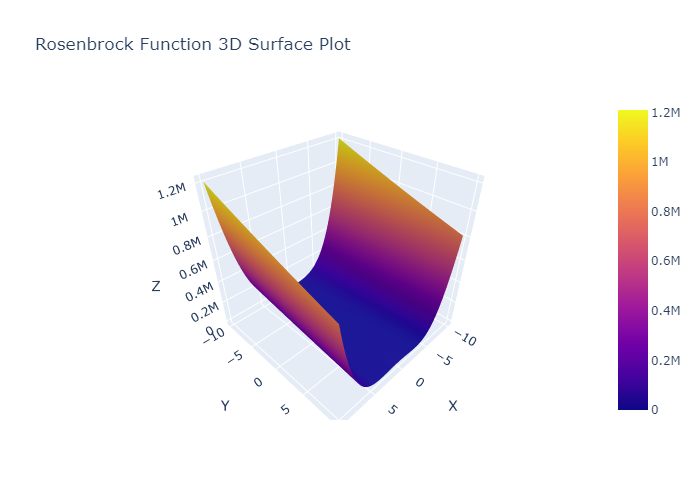

In [2]:
def rosenbrock_plot(x):
    D = len(x)
    f = np.sum(100 * np.power((x[1:D] - np.power(x[:D-1], 2)), 2) + np.power(np.ones(D-1) - x[:D-1], 2))
    df = np.zeros(D)
    df[:D-1] = -400 * x[:D-1] * (x[1:D] - np.power(x[:D-1],2)) - 2 * (np.ones(D-1) - x[:D-1])
    df[1:D] += 200 * (x[1:D] - np.power(x[:D-1],2))
    return f, df

x = np.linspace(-10, 10, 100)
y = np.linspace(-10, 10, 100)
X, Y = np.meshgrid(x, y)
Z = np.zeros((len(X), len(Y)))
for i in range(100):
    for j in range(100):
        Z[i,j] = rosenbrock_plot(np.array([X[i,j], Y[i,j]]))[0]

fig = go.Figure(data=[go.Surface(x=X, y=Y, z=Z)])
fig.update_layout(
    title='Rosenbrock Function 3D Surface Plot',
    scene=dict(
        xaxis_title='X',
        yaxis_title='Y',
        zaxis_title='Z',))
pyo.plot(fig, filename='plotly/rosenbrock-function-3D-surface-plot.html')
pio.write_image(fig, 'plotly/rosenbrock-function-3D-surface-plot.png')
display(Image(filename='plotly/rosenbrock-function-3D-surface-plot.png'))

<a href="https://htmlpreview.github.io/?https://raw.githubusercontent.com/dariayakovchuk/Optimization-Mini-Project/main/plotly/rosenbrock-function-3D-surface-plot.html" target="_blank">View Rosenbrock function made in Plotly</a>

In [19]:
n = 5
global_min = torch.ones(n)
xs = torch.ones(n) * 10

print("Initial value: ", rosenbrock(xs)[0])
print("Global minimum: ", rosenbrock(global_min)[0])

Initial value:  tensor(3240324.)
Global minimum:  tensor(0.)


In [20]:
# Tuning function with optuna

tune_iterations = 2500 
n_trials = 50
test_iterations = 4 * tune_iterations
x0 = xs.tolist()

potential = rosenbrock
optuna.logging.disable_default_handler()

def hyper_tuning(ranges, ranges_integer, optimizer, tune_iterations=1000, n_trials=100, **fixed_pars):
    def optimizer_func(trial):
        pars = {}
        for par, range in ranges.items(): pars[par] = trial.suggest_float(par, *range)
        for par, range in ranges_integer.items(): pars[par] = trial.suggest_int(par, *range)
        xs, _, _ = optimizer(x0, potential, iterations=tune_iterations, **pars, **fixed_pars)
        return potential(xs)[0]
    study = optuna.create_study(direction='minimize')
    study.optimize(optimizer_func, n_trials=n_trials)
    best = study.best_params
    loss = study.best_value
    return best, loss

best_par_sgd, loss_sgd = hyper_tuning({'lr': [1e-10,1e-5], 'momentum': [0,1.0]}, {}, sgd_optimizer, tune_iterations=tune_iterations, n_trials=n_trials)
print("sgd:", best_par_sgd, "\t loss:", loss_sgd)

sgd: {'lr': 9.936694699312874e-06, 'momentum': 0.9871178967245519} 	 loss: 0.12003940343856812


In [21]:
best_par_adam, loss_adam = hyper_tuning({'lr': [1e-10,.5]},{}, adam_optimizer, tune_iterations=tune_iterations, n_trials=n_trials)
print("adam:", best_par_adam, "\t loss:", loss_adam)

adam: {'lr': 0.4995037624999818} 	 loss: 6.829309940338135


In [22]:
best_par_bbi, loss_bbi = hyper_tuning({'lr': [1e-6,1e-2]},{}, BBI_optimizer, tune_iterations=tune_iterations,  n_trials=n_trials,
    threshold0 = 1e20, threshold = 1e25, deltaEn = 0.0, v0 = 1e-22,  n_fixed_bounces = 0 , consEn = True)
print("bbi:", best_par_bbi, "\t loss:", loss_bbi)

bbi: {'lr': 0.007164490124087818} 	 loss: 2.0512658238658332e-10


Loss adam: 5.020694970880868e-10
Loss sgd: 0.0001235918898601085
Loss bbi: 6.281197784119286e-11


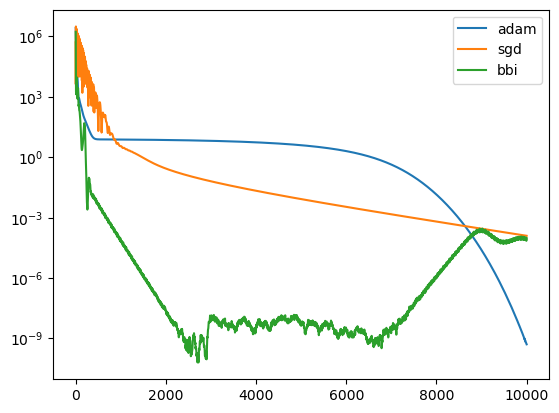

In [23]:
best_par_bbi['deltaEn'] = 0.0
best_par_bbi['v0'] = 1e-22
best_par_bbi['threshold0'] = 1e25
best_par_bbi['threshold'] = 1e20
best_par_bbi['n_fixed_bounces'] = 0
best_par_bbi['consEn'] = True

x0 = xs.tolist()
_, xslist_bbi, _ = BBI_optimizer(x0, potential, iterations=test_iterations, **best_par_bbi)
_, xslist_adam, _ = adam_optimizer(x0, potential, iterations=test_iterations, **best_par_adam)
_, xslist_sgd, _ = sgd_optimizer(x0, potential, iterations=test_iterations, **best_par_sgd)

name = ["adam", "sgd", "bbi"]
n = 0
for lists in [xslist_adam, xslist_sgd, xslist_bbi]:
    min_temp = 10e20
    for elem in lists:
        elem_tens_val, _ = rosenbrock(torch.tensor(elem))
        if elem_tens_val < min_temp:
            min_temp = elem_tens_val.item()
    print(f"Loss {name[n]}: {min_temp}")
    n += 1

def plotting(f, lists, names):
    n = 0
    for xs_list in lists:
        val = []
        for point in xs_list:
            val.append(f(torch.tensor(point))[0])
        val = torch.stack(val)
        plt.plot(val, label = f"{names[n]}")
        n += 1
    plt.legend()
    plt.yscale('log')
    plt.show()

plotting(rosenbrock, [xslist_adam, xslist_sgd, xslist_bbi], ["adam", "sgd", "bbi"])

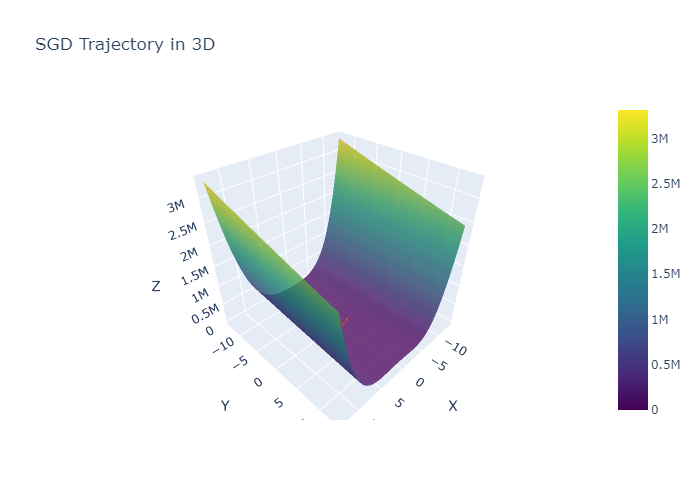

In [25]:
best, xslist_sgd, trajectory = sgd_optimizer(x0, potential, iterations=test_iterations, **best_par_sgd)

# surface data
x = np.linspace(-13, 13, 100)
y = np.linspace(-13, 13, 100)
X, Y = np.meshgrid(x, y)
Z = np.zeros((100, 100))
for i in range(100):
    for j in range(100):
        Z[i,j] = rosenbrock_plot(np.array([X[i,j], Y[i,j]]))[0]

# Create the trajectory
trajectory_x = [pos[0] for pos in trajectory]
trajectory_y = [pos[1] for pos in trajectory]
trajectory_z = [rosenbrock_plot(np.array([pos[0], pos[1]]))[0] for pos in trajectory]

surface = go.Surface(x=X, y=Y, z=Z, colorscale='Viridis', opacity=0.8)
trajectory = go.Scatter3d(x=trajectory_x, y=trajectory_y, z=trajectory_z, mode='lines', marker=dict(size=4))
layout = go.Layout(scene=dict(xaxis=dict(title='X'), yaxis=dict(title='Y'), zaxis=dict(title='Z')), title='SGD Trajectory in 3D')
fig = go.Figure(data=[surface, trajectory], layout=layout)
pyo.plot(fig, filename='plotly/Rosenbrock-SGD-trajectory-in-3D.html')
pio.write_image(fig, 'plotly/Rosenbrock-SGD-trajectory-in-3D.png')
display(Image(filename='plotly/Rosenbrock-SGD-trajectory-in-3D.png'))

<a href="https://htmlpreview.github.io/?https://raw.githubusercontent.com/dariayakovchuk/Optimization-Mini-Project/main/plotly/Rosenbrock-SGD-trajectory-in-3D.html" target="_blank">View SGD performans on Rosenbrock function made in Plotly</a>

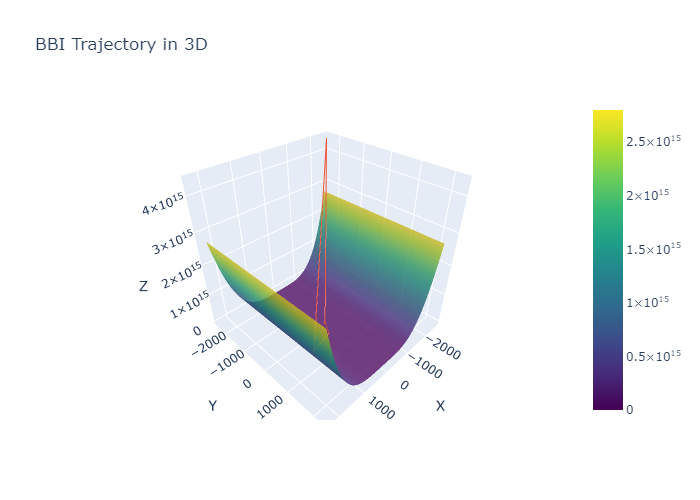

In [37]:
x0 = xs.tolist()
best, xslist_bbi, trajectory = BBI_optimizer(x0, potential, iterations=test_iterations, **best_par_bbi)

# surface data
x = np.linspace(-2300, 2300, 100)
y = np.linspace(-2300, 2300, 100)
X, Y = np.meshgrid(x, y)
Z = np.zeros((100, 100))
for i in range(100):
    for j in range(100):
        Z[i,j] = rosenbrock_plot(np.array([X[i,j], Y[i,j]]))[0]

# Create the trajectory
trajectory_x = [pos[0] for pos in trajectory]
trajectory_y = [pos[1] for pos in trajectory]
trajectory_z = [rosenbrock_plot(np.array([pos[0], pos[1]]))[0] for pos in trajectory]

surface = go.Surface(x=X, y=Y, z=Z, colorscale='Viridis', opacity=0.8)
trajectory = go.Scatter3d(x=trajectory_x, y=trajectory_y, z=trajectory_z, mode='lines', marker=dict(size=4))
layout = go.Layout(scene=dict(xaxis=dict(title='X'), yaxis=dict(title='Y'), zaxis=dict(title='Z')), title='BBI Trajectory in 3D')
fig = go.Figure(data=[surface, trajectory], layout=layout)
pyo.plot(fig, filename='plotly/Rosenbrock-BBI-trajectory-in-3D.html')
pio.write_image(fig, 'plotly/Rosenbrock-BBI-trajectory-in-3D.png')
display(Image(filename='plotly/Rosenbrock-BBI-trajectory-in-3D.png'))

<a href="https://htmlpreview.github.io/?https://raw.githubusercontent.com/dariayakovchuk/Optimization-Mini-Project/main/plotly/Rosenbrock-BBI-trajectory-in-3D.html" target="_blank">View BBI performans on Rosenbrock function made in Plotly</a>

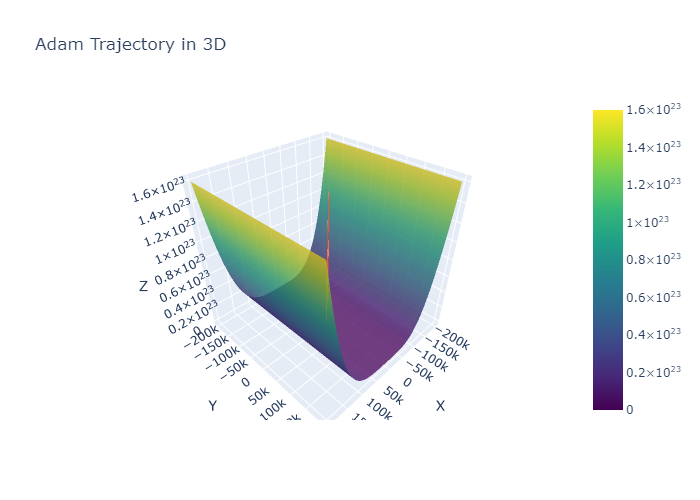

In [47]:
best, xslist_bbi, trajectory = adam_optimizer(x0, potential, iterations=test_iterations, **best_par_adam)

# surface data
x = np.linspace(-2e5, 2e5, 100)
y = np.linspace(-2e5, 2e5, 100)
X, Y = np.meshgrid(x, y)
Z = np.zeros((100, 100))
for i in range(100):
    for j in range(100):
        Z[i,j] = rosenbrock_plot(np.array([X[i,j], Y[i,j]]))[0]

# Create the trajectory
trajectory_x = [pos[0] for pos in trajectory]
trajectory_y = [pos[1] for pos in trajectory]
trajectory_z = [rosenbrock_plot(np.array([pos[0], pos[1]]))[0] for pos in trajectory]

surface = go.Surface(x=X, y=Y, z=Z, colorscale='Viridis', opacity=0.8)
trajectory = go.Scatter3d(x=trajectory_x, y=trajectory_y, z=trajectory_z, mode='lines', marker=dict(size=4))
layout = go.Layout(scene=dict(xaxis=dict(title='X'), yaxis=dict(title='Y'), zaxis=dict(title='Z')), title='Adam Trajectory in 3D')
fig = go.Figure(data=[surface, trajectory], layout=layout)
pyo.plot(fig, filename='plotly/Rosenbrock-Adam-trajectory-in-3D.html')
pio.write_image(fig, 'plotly/Rosenbrock-Adam-trajectory-in-3D.png')
display(Image(filename='plotly/Rosenbrock-Adam-trajectory-in-3D.png'))

<a href="https://htmlpreview.github.io/?https://raw.githubusercontent.com/dariayakovchuk/Optimization-Mini-Project/main/plotly/Rosenbrock-Adam-trajectory-in-3D.html" target="_blank">View Adam performans on Rosenbrock function made in Plotly</a>